- Be sure current working directory is 'demo/' folder:

In [1]:
import os
os.getcwd()

'/home/bohbot/Evyatar/git/Mosquito_Supermodel/src/playground'

- Import required functions:

In [2]:
from sahi.slicing import slice_coco
from sahi.utils.file import load_json

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os
import glob
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import shutil
import multiprocessing
from sahi.utils.coco import Coco

import tempfile
from tqdm import tqdm
from dask import bag as db

import json
import cv2
import uuid

from pathlib import Path

from multiprocessing import Pool

/home/bohbot/miniconda3/envs/super_model/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Optimized version

In [3]:
labels_val_source= labels_train_source = "/home/bohbot/workspace/datasets/mos/1000_each/complete/labels"
images_val_source = images_train_source = "/home/bohbot/workspace/datasets/mos/1000_each/complete/images"
base = "/home/bohbot/workspace/datasets/mos/1000_each/complete"


In [4]:
all_image_paths = (
    [image_path for image_path in glob.iglob(f"{images_train_source}/*") 
     if image_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))] +
    [image_path for image_path in glob.iglob(f"{images_val_source}/*")      if image_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
)

all_annots_paths = (
    [annot_path for annot_path in glob.iglob(f"{labels_train_source}/*") 
     if annot_path.endswith('txt')] +
    [annot_path for annot_path in glob.iglob(f"{labels_val_source}/*") 
     if annot_path.endswith('txt')]
)

In [5]:
annot_dict = {
    os.path.splitext(os.path.basename(annot_path))[0]: annot_path
    for annot_path in all_annots_paths if 'test' not in annot_path
}

image_annot_paths = [
    (image_path, annot_dict[os.path.splitext(os.path.basename(image_path))[0]])
    for image_path in all_image_paths
    if os.path.splitext(os.path.basename(image_path))[0] in annot_dict
]

len(image_annot_paths), image_annot_paths[:2]

(16662,
 [('/home/bohbot/workspace/datasets/mos/1000_each/complete/images/black_white_1_12.jpg',
   '/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/black_white_1_12.txt'),
  ('/home/bohbot/workspace/datasets/mos/1000_each/complete/images/Dangerous_Farm_Insects_Dataset_Thrips_26.jpg',
   '/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/Dangerous_Farm_Insects_Dataset_Thrips_26.txt')])

In [6]:
import os
import shutil
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image

def is_large_annotation(annot_path, img_width, img_height, threshold=0.15):
    try:
        with open(annot_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # malformed line
                _, _, _, w_norm, h_norm = map(float, parts)
                box_area = (w_norm * img_width) * (h_norm * img_height)
                img_area = img_width * img_height
                if box_area / img_area > threshold:
                    return True
    except Exception as e:
        print(f"Error reading {annot_path}: {e}")
    return False

def process_file(file_paths, large_files_dir):
    try:
        image_path, annot_path = file_paths

        if not os.path.exists(image_path) or not os.path.exists(annot_path):
            print(f"Missing file: {image_path} or {annot_path}")
            return

        with Image.open(image_path) as img:
            width, height = img.size

            if width > 1000 or height > 1000:
                if is_large_annotation(annot_path, width, height):
                    return  # Skip due to large annotation

                shutil.copy(image_path, large_files_dir)
                shutil.copy(annot_path, large_files_dir)

    except Exception as e:
        print(f"Error processing {file_paths}: {e}")

def copy_list(image_annot_paths, large_files_dir):
    os.makedirs(large_files_dir, exist_ok=True)
    copied_count = 0
    for file_paths in tqdm(image_annot_paths):
        process_file(file_paths, large_files_dir)
        copied_count += 1
    print(f"Total files copied: {copied_count}")

def copy_large_images(image_annot_paths, large_files_dir):
    os.makedirs(large_files_dir, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max(1, multiprocessing.cpu_count() - 5)) as executor:
        list(executor.map(
            lambda x: process_file(x, large_files_dir),
            image_annot_paths
        ))


In [7]:
source_directory_or_paths = image_annot_paths # folder with both images and txt files
# large_files_directory = '/home/bohbot/Evyatar/git/crop_sahi/large_files' # copies only the large images to a different folder
batch_output_directory = os.path.join(base,'crop') # where to save the crops

In [ ]:
copy_list(image_annot_paths, batch_output_directory)

## 1. convert yolo annotations to coco

In [8]:
def process_image(args):
    image_filename, images_dir, yolo_annotations_dir = args[:3]
    category_mapping = args[3]

    image_path = os.path.join(images_dir, image_filename)
    annotation_filename = os.path.splitext(image_filename)[0] + ".txt"
    annotation_path = os.path.join(yolo_annotations_dir, annotation_filename)

    if not os.path.exists(annotation_path):
        return None, None, None

    image = cv2.imread(image_path)
    if image is None:
        return None, None, None

    height, width, _ = image.shape
    image_id = hash(image_filename)

    image_data = {
        "id": image_id,
        "file_name": image_filename,
        "height": height,
        "width": width
    }

    annotations = []
    categories = []

    with open(annotation_path, "r") as f:
        for line in f:
            line_data = line.strip().split()
            if len(line_data) < 5:
                continue

            category_id = int(line_data[0])
            x_center, y_center, bbox_width, bbox_height = map(float, line_data[1:])

            if category_id not in category_mapping:
                category_mapping[category_id] = f"category_{category_id}"
                categories.append({
                    "id": category_id,
                    "name": category_mapping[category_id],
                    "supercategory": "none"
                })

            x_min = (x_center - bbox_width / 2) * width
            y_min = (y_center - bbox_height / 2) * height
            bbox_width *= width
            bbox_height *= height

            annotations.append({
                "id": len(annotations) + 1,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [x_min, y_min, bbox_width, bbox_height],
                "area": bbox_width * bbox_height,
                "iscrowd": 0
            })

    return annotations, image_data, categories


def convert_yolo_to_coco(yolo_annotations_dir, images_dir, output_json_path):
    os.makedirs(output_json_path, exist_ok=True)
    coco_format = {"images": [], "categories": [], "annotations": []}
    category_mapping = {}

    image_filenames = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

    args = [
        (image_filename, images_dir, yolo_annotations_dir, category_mapping)
        for image_filename in image_filenames
    ]

    with Pool(processes=os.cpu_count()-2) as pool:
        results = list(
            tqdm(pool.imap(process_image, args), total=len(args), desc="Processing images")
        )

    for annotations, image_data, categories in results:
        if annotations and image_data:
            coco_format["annotations"].extend(annotations)
            coco_format["images"].append(image_data)
        if categories:
            coco_format["categories"].extend(categories)

    category_ids = set()
    unique_categories = []
    for category in coco_format["categories"]:
        if category["id"] not in category_ids:
            category_ids.add(category["id"])
            unique_categories.append(category)
    coco_format["categories"] = unique_categories

    with open(f"{output_json_path}/coco_annotations.json", "w") as json_file:
        json.dump(coco_format, json_file, indent=4)

In [9]:
coco_annotations_path = os.path.join(labels_val_source, 'coco')
sliced_images_path = os.path.join(labels_val_source, 'sliced')
temp_image_dir = os.path.join(labels_val_source, 'temp_processing')
yolo_format_dir = os.path.join(labels_val_source, 'yolo_format')

# Create directories if they don't exist
for path in [coco_annotations_path, sliced_images_path, temp_image_dir, yolo_format_dir]:
    os.makedirs(path, exist_ok=True)

In [ ]:
convert_yolo_to_coco(batch_output_directory, batch_output_directory, coco_annotations_path)

## 2. Slicing COCO Dataset into Grids

- To slice a COCO dataset annoations an images, we need to specify slice parameters. In this example we will ice images into 256x256 grids overlap ratio of 0.2:

In [10]:
n_files = len(glob.glob(f"{batch_output_directory}/*txt"))
n_files

6734

In [11]:
batch = n_files
json_out =f"{coco_annotations_path}/coco_annotations.json"
sliced_dir = sliced_images_path

In [12]:
sliced_dir

'/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/sliced'

In [13]:
def split_coco(coco_path):
    with open(coco_path, "r") as f:
        data = json.load(f)
    m = {}
    for img in data["images"]:
        m[img["file_name"]] = {
            "images": [img],
            "annotations": [],
            "categories": data.get("categories", [])
        }
    d = {img["id"]: img["file_name"] for img in data["images"]}
    for ann in data["annotations"]:
        fn = d[ann["image_id"]]
        m[fn]["annotations"].append(ann)
    return m

def process_file(args):
    f, splitted, sliced_dir = args
    name = Path(f).name
    if name not in splitted:
        return f
    o = os.path.join(sliced_dir, Path(f).stem)
    a = os.path.join(o, f"{Path(f).stem}_sliced_annotations.json")
    if os.path.exists(o) and os.path.exists(a):
        return None
    t = os.path.join(sliced_dir, f"temp_processing_{uuid.uuid4()}")
    try:
        os.makedirs(t, exist_ok=True)
        local_coco = os.path.join(t, "annotation.json")
        with open(local_coco, "w") as w:
            json.dump(splitted[name], w)
        shutil.copy(f, t)
        slice_coco(
            coco_annotation_file_path=local_coco,
            image_dir=t,
            output_coco_annotation_file_name=f"{Path(f).stem}_sliced_annotations",
            ignore_negative_samples=False,
            output_dir=o,
            slice_height=640,
            slice_width=640,
            overlap_height_ratio=0.0,
            overlap_width_ratio=0.0,
            min_area_ratio=0.1,
            verbose=False
        )
    except Exception:
        return f
    finally:
        if os.path.exists(t):
            shutil.rmtree(t)
    return None

def run_processing(batch_output_directory, sliced_dir, coco_file, processes=4):
    splitted = split_coco(coco_file)
    image_files = [
        x for x in glob.iglob(os.path.join(batch_output_directory, "*"))
        if not x.lower().endswith(".txt")
    ]
    with Pool(processes=processes) as p:
        r = p.map(
            process_file,
            [(f, splitted, sliced_dir) for f in image_files]
        )
    m = [x for x in r if x]
    if m:
        with open("missing_files.log", "w") as w:
            w.write("\n".join(m))
    return m

In [ ]:
sliced_dir

In [ ]:
missing_files = run_processing(
    batch_output_directory,
    sliced_dir,
    json_out,
    processes=os.cpu_count()-7
)

In [ ]:
sliced_dir

- Convert back to yolo

In [14]:
def _process_folder(args):
    folder_name, batch_output_directory, source_directory = args
    batch_path = os.path.join(batch_output_directory, folder_name)
    if not os.path.isdir(batch_path):
        return
    sliced_coco_path = os.path.join(
        batch_path, f"{os.path.basename(batch_path)}_sliced_annotations_coco.json"
    )
    if not os.path.exists(sliced_coco_path):
        return
    coco = Coco.from_coco_dict_or_path(sliced_coco_path, image_dir=batch_path)
    coco.export_as_yolov5(
        output_dir=source_directory,
        train_split_rate=1,
        disable_symlink=True
    )

def export_all_sliced_to_yolo(batch_output_directory, source_directory, processes=4):
    folders = sorted(os.listdir(batch_output_directory))
    with Pool(processes=processes) as pool:
        pool.map(
            _process_folder,
            [(f, batch_output_directory, source_directory) for f in folders]
        )

In [ ]:
export_all_sliced_to_yolo(sliced_dir, yolo_format_dir, processes=os.cpu_count()-5)

- Visualize sliced annotations on sliced images:

In [15]:
import os
import random
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def plot_random_images_with_yolo_annotations(source_directory, num_images=5):
    image_files = []
    for f in os.listdir(source_directory):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            image_files.append(os.path.join(source_directory, f))

    if not image_files:
        print("No images found in:", source_directory)
        return
    
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(16, 5))
    if len(selected_images) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, selected_images):
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)
        width, height = img.size

        label_path = os.path.splitext(img_path)[0] + ".txt"
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cat_id = parts[0]
                    x_c, y_c, w, h = map(float, parts[1:])
                    x1 = int((x_c - w / 2) * width)
                    y1 = int((y_c - h / 2) * height)
                    x2 = int((x_c + w / 2) * width)
                    y2 = int((y_c + h / 2) * height)
                    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                    draw.text((x1, y1), f"Class {cat_id}", fill="red")

        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=5)
        print(img_path)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/males_ANNOTATION_10048_rep1_DEE+D_0_0_0_640_640.png
/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/video0005 24-08-28 15-30-42_frame1740_0_1280_0_1920_640.png
/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/IMG_7631_frame4368_0_0_660_640_1300.png
/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/video0005 24-08-28 15-30-42_frame2220_0_0_440_640_1080.png
/home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/video0005 24-08-28 15-30-42_frame1770_0_1280_440_1920_1080.png


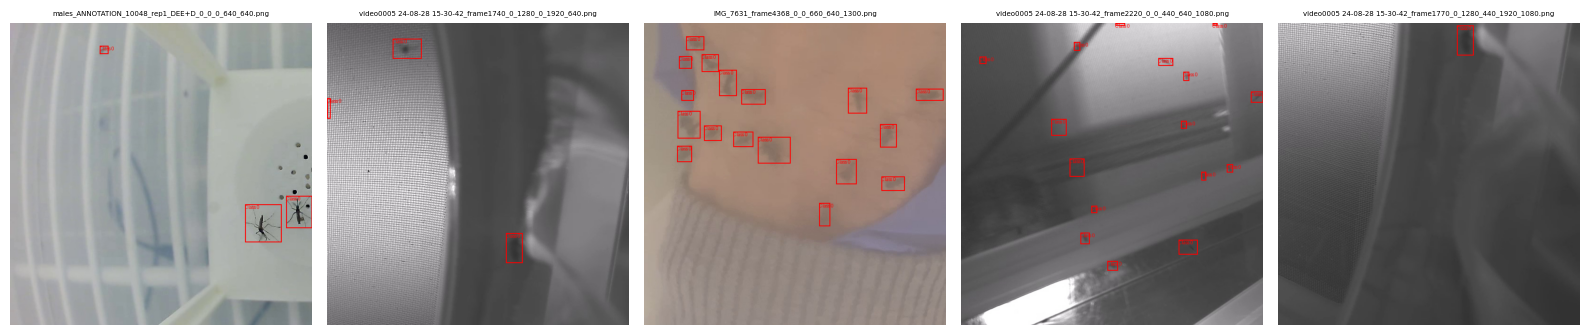

In [32]:
plot_random_images_with_yolo_annotations(f"{yolo_format_dir}/train", num_images=5)

In [46]:
import os

def count_background_images(folder):
    bg_count = 0
    total = 0
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.txt'):
                total += 1
                txt_path = os.path.join(root, file)
                with open(txt_path, 'r') as f:
                    if not f.read().strip():
                        bg_count += 1
    print(f"\nTotal label files: {total}")
    print(f" Background (empty) label files: {bg_count}")

count_background_images("/home/bohbot/workspace/datasets/mos/1000_each/full_dataset/labels/val")
count_background_images("/home/bohbot/workspace/datasets/mos/1000_each/full_dataset/labels/train")
887+3541
8511+34033



Total label files: 8511
 Background (empty) label files: 887

Total label files: 34033
 Background (empty) label files: 3541


42544

In [35]:
import os
import random

def delete_random_backgrounds(folder, percentage=0.2, image_extensions={'.jpg', '.jpeg', '.png', '.bmp', '.tif'}):
    bg_files = []

    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.txt'):
                txt_path = os.path.join(root, file)
                with open(txt_path, 'r') as f:
                    if not f.read().strip():
                        base_name = os.path.splitext(file)[0]
                        for ext in image_extensions:
                            image_path = os.path.join(root, base_name + ext)
                            if os.path.exists(image_path):
                                bg_files.append((txt_path, image_path))
                                break

    delete_count = int(len(bg_files) * percentage)
    to_delete = random.sample(bg_files, delete_count)

    for txt_path, img_path in to_delete:
        os.remove(txt_path)
        os.remove(img_path)
        print(f"🗑️ Deleted: {img_path} + {txt_path}")

    print(f"\n✅ Deleted {delete_count} background image(s) out of {len(bg_files)}")

# Example usage
delete_random_backgrounds(f"{yolo_format_dir}/train", percentage=0.70)


🗑️ Deleted: /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/MVI_5696_600_0_0_440_640_1080.png + /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/MVI_5696_600_0_0_440_640_1080.txt
🗑️ Deleted: /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/model_23_0_0_440_640_1080.png + /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/model_23_0_0_440_640_1080.txt
🗑️ Deleted: /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/2023-07-13_18-19-14_cam3_frame_91_0_1280_440_1920_1080.png + /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/2023-07-13_18-19-14_cam3_frame_91_0_1280_440_1920_1080.txt
🗑️ Deleted: /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/c3_24_02_25__14_20_58_120147_0_1280_1920_1920_2560.png + /home/bohbot/workspace/datasets/mos/1000_each/complete/labels/yolo_format/train/c3_

## Split to train and val

In [37]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

def split_yolo_dataset(input_dir, output_dir, val_size=0.2, random_state=42):
    """
    Splits YOLO images and annotations into train/val sets,
    keeping background and foreground distributions separate.

    Args:
        input_dir (str): Folder containing images and corresponding YOLO .txt files.
        output_dir (str): Output root folder to store split images/labels in train/val subfolders.
        val_size (float): Proportion of data to use for validation.
        random_state (int): Seed for reproducibility.
    """

    # Collect foreground and background pairs
    fg_images, fg_annots = [], []
    bg_images, bg_annots = [], []

    for file in os.listdir(input_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_dir, file)
            annot_file = os.path.splitext(file)[0] + '.txt'
            annot_path = os.path.join(input_dir, annot_file)

            # Create empty annotation file if missing
            if not os.path.exists(annot_path):
                with open(annot_path, 'w') as f:
                    pass
                print(f"Created empty annotation file: {annot_path}")

            # Check if annotation is empty (background)
            with open(annot_path, 'r') as f:
                content = f.read().strip()

            if content:
                fg_images.append(file)
                fg_annots.append(annot_file)
            else:
                bg_images.append(file)
                bg_annots.append(annot_file)

    # Split both groups independently
    def split_group(images, annots):
        return train_test_split(images, annots, test_size=val_size, random_state=random_state)

    fg_train_imgs, fg_val_imgs, fg_train_anns, fg_val_anns = split_group(fg_images, fg_annots)
    bg_train_imgs, bg_val_imgs, bg_train_anns, bg_val_anns = split_group(bg_images, bg_annots)

    # Merge the splits
    train_images = fg_train_imgs + bg_train_imgs
    val_images = fg_val_imgs + bg_val_imgs
    train_annots = fg_train_anns + bg_train_anns
    val_annots = fg_val_anns + bg_val_anns

    # Create output folders
    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

    # Copy training files
    for img, ann in zip(train_images, train_annots):
        copyfile(os.path.join(input_dir, img), os.path.join(output_dir, 'images', 'train', img))
        copyfile(os.path.join(input_dir, ann), os.path.join(output_dir, 'labels', 'train', ann))

    # Copy validation files
    for img, ann in zip(val_images, val_annots):
        copyfile(os.path.join(input_dir, img), os.path.join(output_dir, 'images', 'val', img))
        copyfile(os.path.join(input_dir, ann), os.path.join(output_dir, 'labels', 'val', ann))

    print(f"\n✅ Split complete:")
    print(f"Train → {len(train_images)} (FG: {len(fg_train_imgs)}, BG: {len(bg_train_imgs)})")
    print(f"Val   → {len(val_images)} (FG: {len(fg_val_imgs)}, BG: {len(bg_val_imgs)})")

# Example usage:



In [39]:
split_yolo_dataset(input_dir="/home/bohbot/workspace/datasets/mos/1000_each/slice_size", output_dir="/home/bohbot/workspace/datasets/mos/1000_each/full_dataset")


✅ Split complete:
Train → 26708 (FG: 23552, BG: 3156)
Val   → 6678 (FG: 5888, BG: 790)


In [ ]:
import os
import shutil
from multiprocessing import Pool, cpu_count


def get_image_files(folder, image_extensions):
    return [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in image_extensions]


def prepare_tasks(main_folder, test_folders, image_extensions):
    os.makedirs(main_folder, exist_ok=True)
    main_files = set(os.listdir(main_folder))
    tasks = []

    for test_folder in test_folders:
        test_files = get_image_files(test_folder, image_extensions)
        for file in test_files:
            if file not in main_files:
                src = os.path.join(test_folder, file)
                dst = os.path.join(main_folder, file)
                tasks.append((src, dst, file))
    return tasks


def copy_file(task):
    src, dst, file = task
    try:
        shutil.copy2(src, dst)
        print(f"✅ Copied: {file}")
    except Exception as e:
        print(f"❌ Failed to copy {file}: {e}")


def move_missing_images_to_main_parallel(main_folder, test_folders, image_extensions={'.txt'}):
    tasks = prepare_tasks(main_folder, test_folders, image_extensions)

    print(f"Starting copy of {len(tasks)} files using {cpu_count()} cores...")

    with Pool(processes=cpu_count()) as pool:
        pool.map(copy_file, tasks)

    print("✅ Done.")


# Example usage
main = '/home/bohbot/workspace/datasets/mos/main_images/labels'
tests = [
    '/home/bohbot/workspace/datasets/mos/originals_for_features/labels',
    '/home/bohbot/workspace/datasets/mos/originals_size_features/labels',
    '/home/bohbot/workspace/datasets/mos/test/labels',
    '/home/bohbot/workspace/datasets/mos/batch4',
    
]

move_missing_images_to_main_parallel(main, tests)


In [ ]:
import os

def clean_unmatched_files(txt_folder, image_folder, image_extensions={'.jpg', '.jpeg', '.png', '.bmp', '.tif'}):
    txt_files = [f for f in os.listdir(txt_folder) if f.endswith('.txt')]
    image_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in image_extensions]

    txt_basenames = {os.path.splitext(f)[0] for f in txt_files}
    img_basenames = {os.path.splitext(f)[0] for f in image_files}

    # Delete .txt files with no matching image
    for base in txt_basenames - img_basenames:
        txt_path = os.path.join(txt_folder, base + '.txt')
        if os.path.exists(txt_path):
            os.remove(txt_path)
            print(f"🗑️ Deleted label (no image): {txt_path}")

    # Delete images with no matching .txt file
    for base in img_basenames - txt_basenames:
        for ext in image_extensions:
            img_path = os.path.join(image_folder, base + ext)
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"🗑️ Deleted image (no label): {img_path}")
                break

# Example usage:
txt_folder = main = '/home/bohbot/workspace/datasets/mos/main_images/labels'
image_folder = main = '/home/bohbot/workspace/datasets/mos/main_images/images'

clean_unmatched_files(txt_folder, image_folder)


In [ ]:
import os

def add_prefix_to_files(folder_path, prefix="black_white_"):
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        if os.path.isfile(old_path):
            new_filename = prefix + filename
            new_path = os.path.join(folder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"✅ Renamed: {filename} → {new_filename}")

# Example usage:
folder = '/home/bohbot/Evyatar/git/Mosquito_Supermodel/runs/detect/predict2/labels - Copy'
add_prefix_to_files(folder)


In [ ]:
yolo detect model="/home/bohbot/Evyatar/runs/detect/1000_each/weights/best.pt" source ="/home/bohbot/workspace/images/supermodel/640X640/images/val"

In [ ]:
yolo detect predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg' 